In [3]:
!pip install tensorflow matplotlib seaborn scikit-learn gradio

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



img_height = 124
img_width = 124
img_size = (img_height, img_width)
batch_size = 32
data_dir = "dataset" 

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetV2B2

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Input
inputs = Input(shape=(124, 124, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Base model
base_model = EfficientNetV2B2(weights="imagenet", include_top=False, input_tensor=x)
base_model.trainable = True  # 🔓 Unfreeze base model

# Custom head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)
# ✅ Save the trained model for later use
model.save("garbage_classifier.keras")


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6108 - loss: 1.0922 - val_accuracy: 0.6000 - val_loss: 1.0937
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6311 - loss: 1.0585 - val_accuracy: 0.5901 - val_loss: 1.0583
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6145 - loss: 1.0480 - val_accuracy: 0.6178 - val_loss: 1.0616
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6358 - loss: 1.0310 - val_accuracy: 0.6495 - val_loss: 0.9990
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6389 - loss: 1.0145 - val_accuracy: 0.6416 - val_loss: 0.9951
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6525 - loss: 0.9767 - val_accuracy: 0.6475 - val_loss: 0.9553
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6689 - loss: 0.9627 - val_accuracy: 0.6554 - val_loss: 0.9609
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6688 - loss: 0.9124 - val_accuracy: 0.6653 - v

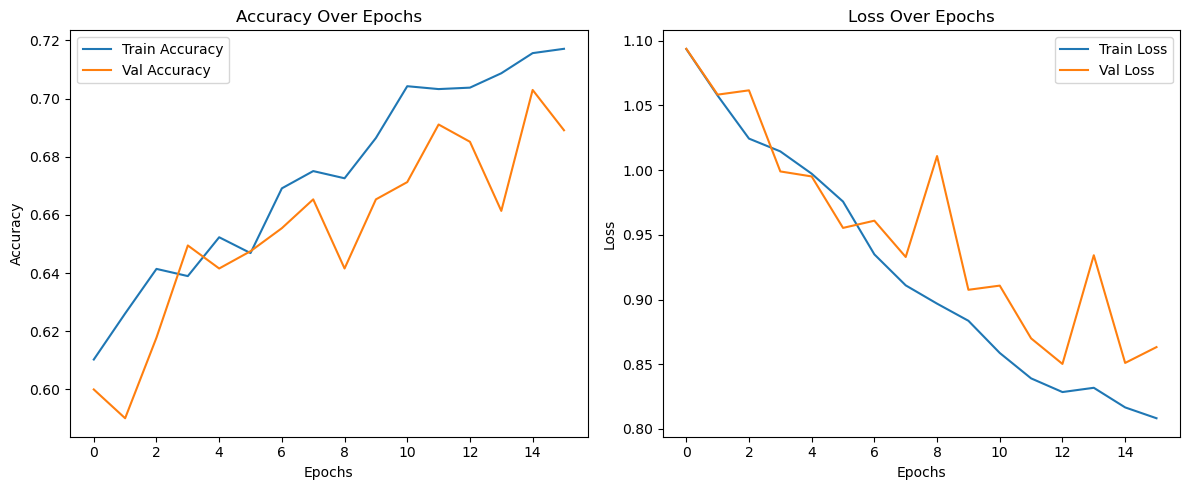

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
              precision    recall  f1-score   support

   cardboard       0.88      0.62      0.73        69
       glass       0.58      0.55      0.56       102
       metal       0.55      0.75      0.64        88
       paper       0.78      0.91      0.84       123
     plastic       0.89      0.57      0.70        89
       trash       0.46      0.53      0.49        

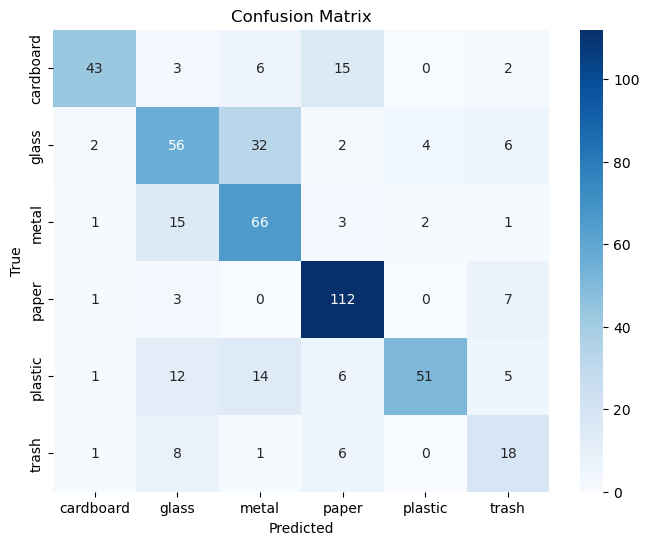

In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [18]:
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load saved model (.keras)
model = tf.keras.models.load_model("garbage_classifier.keras")

# Class names must match training order
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def classify_image(img):
    # Resize and normalize image to match training input
    img = img.resize((124, 124))
    img_array = np.array(img) / 255.0  # normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dim
    
    # Make prediction
    predictions = model.predict(img_array)[0]  # [0] to get 1D array
    result = {class_names[i]: float(predictions[i]) for i in range(len(class_names))}
    
    return result


In [3]:
!pip install tensorflow matplotlib seaborn scikit-learn gradio

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



img_height = 124
img_width = 124
img_size = (img_height, img_width)
batch_size = 32
data_dir = "dataset" 

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetV2B2

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Input
inputs = Input(shape=(124, 124, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Base model
base_model = EfficientNetV2B2(weights="imagenet", include_top=False, input_tensor=x)
base_model.trainable = True  # 🔓 Unfreeze base model

# Custom head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.1974 - loss: 1.8264 - val_accuracy: 0.1762 - val_loss: 1.8445
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.2587 - loss: 1.7480 - val_accuracy: 0.3030 - val_loss: 1.6767
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3225 - loss: 1.6726 - val_accuracy: 0.3564 - val_loss: 1.6120
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3754 - loss: 1.6012 - val_accuracy: 0.4475 - val_loss: 1.5438
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4222 - loss: 1.5206 - val_accuracy: 0.4713 - val_loss: 1.4815
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4729 - loss: 1.4654 - val_accuracy: 0.4950 - val_loss: 1.4181
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4767 - loss: 1.4192 - val_accuracy: 0.4812 - val_loss: 1.4533
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5113 - loss: 1.3512 - val_accuracy: 0.4891 - va

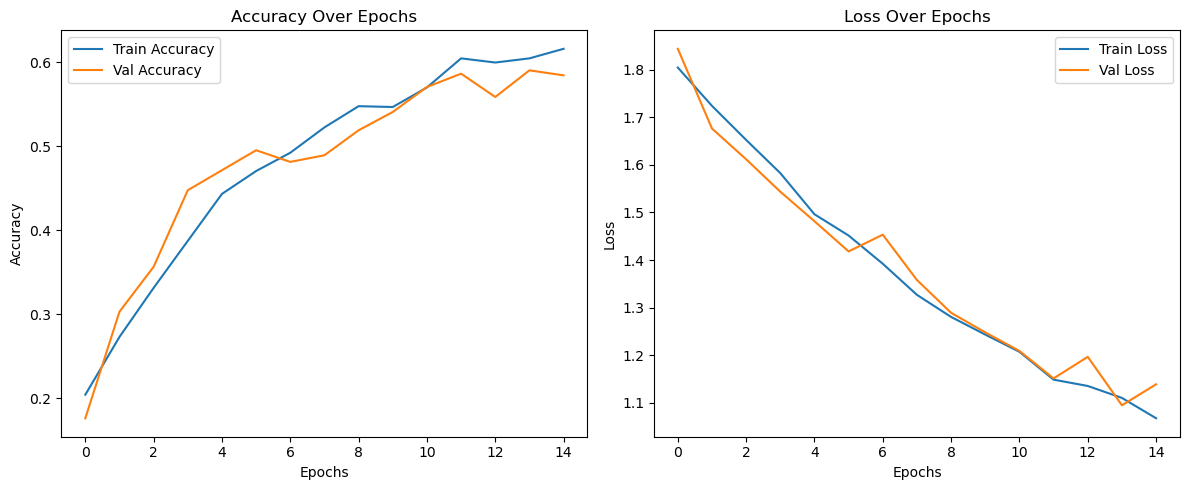

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
              precision    recall  f1-score   support

   cardboard       0.88      0.62      0.73        69
       glass       0.58      0.55      0.56       102
       metal       0.55      0.75      0.64        88
       paper       0.78      0.91      0.84       123
     plastic       0.89      0.57      0.70        89
       trash       0.46      0.53      0.49        34

  

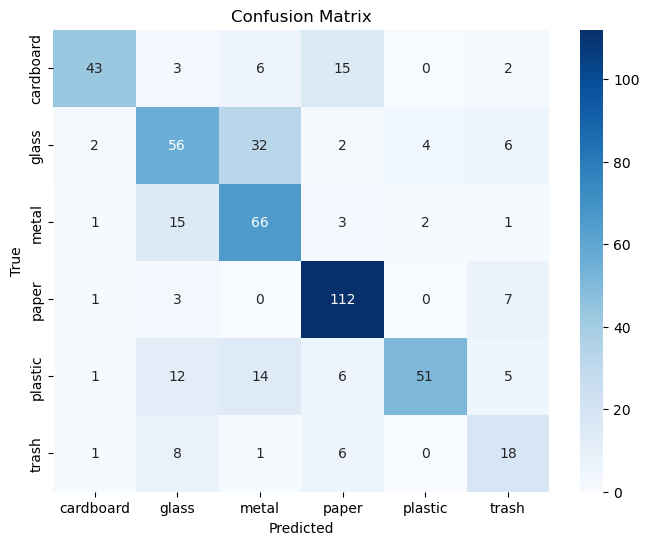

In [19]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

model.save("garbage_classifier.keras")


In [4]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Constants
img_width = 124
img_height = 124
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Load the model
model = load_model("best_model.keras")

# Preprocess and predict function
def classify_image(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize((img_width, img_height))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dim

    preds = model.predict(image)[0]
    predicted_label = class_names[np.argmax(preds)]
    confidence = round(100 * np.max(preds), 2)

    return f"{predicted_label} ({confidence}%)"

# Gradio interface
gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classifier",
    description="Upload an image to classify it as cardboard, glass, metal, paper, plastic, or trash."
).launch(share=True)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://467bcf6d19375448ce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
